# Pronóstico de la cotización diaria de Repsol usando GRU y entradas estáticas de Repsol

In [87]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
import torch.optim as optim
from torchmetrics import MeanMetric
import torch.nn.functional as fnn
from sklearn.preprocessing import StandardScaler

## Análisis Exploratorio de Datos

En esta sección se importarán los datos historicos de la cotización de Repsol y se les realizará un breve análisis descriptivo.

### Importación del Dataset

La información se obtendrá a través de yahoo finance desde la fecha más alejada posible hasta el 16 de mayo de 2025 inclusive.

In [88]:
ticker = yf.Ticker("REP.MC")
repsol = ticker.history(interval="1d", end="2025-05-17", period="max")
repsol.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00+01:00,6.435030,6.566528,6.127268,6.166438,3215655,0.0,0.0
2000-01-04 00:00:00+01:00,6.127268,6.180427,5.917430,5.959398,3244446,0.0,0.0
2000-01-05 00:00:00+01:00,5.875462,6.006960,5.819505,5.878260,3235272,0.0,0.0
2000-01-06 00:00:00+01:00,5.878260,5.878260,5.878260,5.878260,0,0.0,0.0
2000-01-07 00:00:00+01:00,5.945408,6.174831,5.942611,6.062918,5914766,0.0,0.0


### Análisis exploratorio

**Fecha de inicio y Fin**

In [89]:
print("Inicio: ", repsol.index[0])
print("Fin:    ", repsol.index[-1])

Inicio:  2000-01-03 00:00:00+01:00
Fin:     2025-05-16 00:00:00+02:00


**Tipos de Dato y descripciones de las columnas**

In [90]:
repsol.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6515 entries, 2000-01-03 00:00:00+01:00 to 2025-05-16 00:00:00+02:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          6515 non-null   float64
 1   High          6515 non-null   float64
 2   Low           6515 non-null   float64
 3   Close         6515 non-null   float64
 4   Volume        6515 non-null   int64  
 5   Dividends     6515 non-null   float64
 6   Stock Splits  6515 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 407.2 KB


In [91]:
repsol.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,6515.000000,6515.000000,6515.000000,6515.000000,6.515000e+03,6515.000000,6515.0
mean,7.929623,8.019678,7.834448,7.925528,9.943002e+06,0.002689,0.0
std,2.402492,2.417836,2.388359,2.401723,9.967070e+06,0.032006,0.0
min,3.202196,3.240920,3.023469,3.202196,0.000000e+00,0.000000,0.0
25%,6.025398,6.120362,5.932913,6.022769,5.158120e+06,0.000000,0.0
50%,7.930576,8.022504,7.827603,7.921728,7.490957e+06,0.000000,0.0
75%,9.475081,9.570968,9.374036,9.477766,1.129813e+07,0.000000,0.0
max,14.956361,15.058484,14.905300,15.016706,2.534970e+08,0.868400,0.0


**Observaciones**:
1.  Nunca se ha dividido la acción.
2.  Volumen tiene algunos datos faltantes representados como 0.
3.  Los datos van desde el 03/01/2000 hasta 16/05/2025, en total 6515 días activos.

### Representación Gráfica de la Cotización de Repsol

In [92]:
fig = go.Figure(data=[go.Ohlc(
    x=repsol.index,
    open=repsol['Open'],
    high=repsol['High'],
    low=repsol['Low'],
    close=repsol['Close'],
    increasing_line_color='green',
    decreasing_line_color='red'
)])
fig.update_layout(
    title="Cotización diaria de Repsol",
    xaxis_title='Fecha',
    yaxis_title='Precio(€)',
    template='plotly_dark',
    height=700
)
fig.show()

**Observaciones**
1. Algunos valores no son correctos, Respol alcanzó una cotización cercana a los 30€ en Julio de 2007 y claramente no se refleja en el gráfico.
2. El último precio de cierre real sí corresponde con el mostrado: 11.79€.

*Nota*: En la web de yahoo finance los precios pasados se muestran correctamente, desconozco el motivo de esta divergercia.

## Limpieza de Datos

En este apartado se lidiará con los valores faltantes y variables que no aporten valor.

### Eliminación de Stock Splits  
Esta columna solo contiene ceros, por tanto no aporta valor.

In [93]:
repsol = repsol.drop('Stock Splits', axis=1)
repsol.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends'], dtype='object')

### Imputación de nulos

In [94]:
(repsol['Volume'] == 0).sum()

79

**Observaciones**:  
Tiene muy pocos valores sin información, cerca del 1,21%

Para rellenar los nulos se realizará una interpolación temporal

In [95]:
repsol['Volume']= repsol['Volume'].replace(0, np.nan)
repsol['Volume'] = repsol['Volume'].interpolate(method="time")
repsol['Volume'].isna().sum()

0

## Ingeniería de Características

### Creación de nuevas características  

**Cierre Anterior**

In [96]:
repsol['Cierre_Anterior'] = repsol['Close'].shift(1)

**EMAs de 12 y 26 periodos**  
Crean lineas suavizando el precio de un activo dentro de una ventana temporal, dando más peso a los datos recientes. 
Se utilizan para identificar tendencias y posibles puntos de entrada o salida en el mercado financiero.

In [97]:
repsol['EMA_12'] = repsol['Close'].ewm(span=12, adjust=False).mean()
repsol['EMA_26'] = repsol['Close'].ewm(span=26, adjust=False).mean()

**SMAs de 5, 20 y 50 periodos**   
Iguales que las EMAs pero dan el mismo peso a todos los datos, reaccionan menos a cambios bruscos de precio haciendola más resistente a un posible ruido

In [98]:
repsol['SMA_5']  = repsol['Close'].rolling(window=5).mean()
repsol['SMA_20'] = repsol['Close'].rolling(window=20).mean()
repsol['SMA_50'] = repsol['Close'].rolling(window=50).mean()

**Lunes y Mes**  
Dado que en los fines de semana no se opera esto puede provocar grandes cambios en el precio de apertura.
Históricamente cada mes se caracteriza por tener cierta tendencia, por ejemplo en Diciembre ocurre el llamado *Rally de Navidad*.

In [99]:
repsol['Dia_semana'] = repsol.index.dayofweek
repsol['Lunes'] = np.where(repsol['Dia_semana'] == 0, 1, 0)
repsol = repsol.drop('Dia_semana', axis=1)
repsol['Mes'] = repsol.index.month

#### Creación de funciones
Algunas características requieren calculos más extensos

**Relative Strength Index (RSI)**  
Valores Altos(>70) indican sobrecompra y valores Bajos(<30) sobreventa.

In [100]:
def rsi(columna, periodo=14):
    """    
    Parámetros:
    - columna: Columna de precios
    - periodo: Número de periodos (por defecto 14)
    
    Devuelve:
    - Serie con los valores del RSI
    """
    delta = columna.diff()

    ganancias = delta.where(delta > 0, 0.0)
    perdidas = -delta.where(delta < 0, 0.0)

    media_ganancias = ganancias.ewm(span=periodo, adjust=False).mean()
    media_perdidas = perdidas.ewm(span=periodo, adjust=False).mean()

    rs = media_ganancias / media_perdidas
    rsi = 100 - (100 / (1 + rs))

    return rsi


In [101]:
repsol['RSI'] = rsi(repsol['Close'])

**Moving Average Convergence Divergence**  
La función devuelve un dataframe con 3 columnas:
* `MACD`: mide la diferencia entre la EMA de corto plazo y la EMA de largo plazo, indicando el momentum del precio.
* `Señal`: es una EMA (por defecto de 9 períodos) del MACD, utilizada para generar señales de compra o venta mediante cruces.
* `Histograma`: representa la diferencia entre el MACD y su línea de señal, reflejando la fuerza y dirección del momentum.


In [102]:
def macd(columna, ema_rapida, ema_lenta, señal=9):
    """    
    Parámetros:
    - columna: Serie de precios
    - ema_rapida: Ema de 12 periodos
    - ema_lenta: Ema de 26 periodos
    - señal: Periodo para la línea de señal (por defecto 9)

    Devuelve:
    - Las columnas 'MACD', 'Señal' y 'Histograma'
    """
    macd = ema_rapida - ema_lenta
    linea_señal = macd.ewm(span=señal, adjust=False).mean()
    histograma = macd - linea_señal

    return macd, linea_señal, histograma

In [103]:
macd, señal, histograma = macd(repsol['Close'], repsol['EMA_12'], repsol['EMA_26'])
repsol['MACD'] = macd
repsol['Señal'] = señal
repsol['Histograma'] = histograma

**Volatilidad**  
Calcula la volatilidad mensual basada en una ventana móvil de retornos logarítmicos.

In [104]:
def volatilidad(columna, ventana = 21):
    """  
    Parámetros:
    - columna: Serie de precios
    - ventana: Periodo de días en el que realizar el cálculo.
               (por defecto 21, el número de días hábiles de un mes).

    Devuelve:
    - Serie con la volatilidad mensual.
    """
    retorno_log_dia = np.log(columna / columna.shift(1))

    volatilidad = retorno_log_dia.rolling(window=ventana).std() * np.sqrt(ventana)
    
    return volatilidad

In [105]:
repsol['Volatilidad'] = volatilidad(repsol['Close'])

**Delta ($\Delta$)**  
Las diferencias proporcionales respecto al cierre anterior para `open`, `low`, `high` y `close`.  
Serán las variables a predecir en vez del precio absoluto.

In [106]:
repsol['delta_open'] = repsol['Open'] / repsol['Cierre_Anterior'] - 1
repsol['delta_high'] = repsol['High'] / repsol['Cierre_Anterior'] - 1
repsol['delta_low'] = repsol['Low'] / repsol['Cierre_Anterior'] - 1
repsol['delta_close'] = repsol['Close'] / repsol['Cierre_Anterior'] - 1

Cambio el orden de las columnas para facilitar la separación entre X e y

In [107]:
repsol.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Cierre_Anterior', 'EMA_12', 'EMA_26', 'SMA_5', 'SMA_20', 'SMA_50',
       'Lunes', 'Mes', 'RSI', 'MACD', 'Señal', 'Histograma', 'Volatilidad',
       'delta_open', 'delta_high', 'delta_low', 'delta_close'],
      dtype='object')

In [108]:
# Cambiar el orden de las columnas
repsol = repsol[['Open', 'High', 'Low', 'Close', 'delta_open', 'delta_high', 'delta_low', 'delta_close', 'Cierre_Anterior', 'Volume', 'Dividends',
                 'EMA_12', 'EMA_26', 'SMA_5', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Señal', 'Histograma', 'Volatilidad', 'Lunes', 'Mes']]
repsol.head()

,Open,High,Low,Close,delta_open,delta_high,delta_low,delta_close,Cierre_Anterior,Volume,...,SMA_5,SMA_20,SMA_50,RSI,MACD,Señal,Histograma,Volatilidad,Lunes,Mes
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00+01:00,6.435030,6.566528,6.127268,6.166438,NaN,NaN,NaN,NaN,NaN,3215655.0,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,1,1
2000-01-04 00:00:00+01:00,6.127268,6.180427,5.917430,5.959398,-6.352024e-03,2.268691e-03,-4.038106e-02,-0.033575,6.166438,3244446.0,...,NaN,NaN,NaN,0.000000,-0.016516,-0.003303,-0.013213,NaN,0,1
2000-01-05 00:00:00+01:00,5.875462,6.006960,5.819505,5.878260,-1.408465e-02,7.981041e-03,-2.347436e-02,-0.013615,5.959398,3235272.0,...,NaN,NaN,NaN,0.000000,-0.035740,-0.009791,-0.025950,NaN,0,1
2000-01-06 00:00:00+01:00,5.878260,5.878260,5.878260,5.878260,2.220446e-16,2.220446e-16,2.220446e-16,0.000000,5.878260,4575019.0,...,NaN,NaN,NaN,0.000000,-0.050395,-0.017911,-0.032483,NaN,0,1
2000-01-07 00:00:00+01:00,5.945408,6.174831,5.942611,6.062918,1.142324e-02,5.045227e-02,1.094727e-02,0.031414,5.878260,5914766.0,...,5.989054,NaN,NaN,48.546052,-0.046571,-0.023643,-0.022928,NaN,0,1


#### Limpieza de Nulos
Debido a que las nuevas características han sido creadas con la intervención de funciones de ventana, las primeras 49 filas contienen nulos no interpolables

In [109]:
repsol.iloc[0:49].isna().sum()

Open                0
High                0
Low                 0
Close               0
delta_open          1
delta_high          1
delta_low           1
delta_close         1
Cierre_Anterior     1
Volume              0
Dividends           0
EMA_12              0
EMA_26              0
SMA_5               4
SMA_20             19
SMA_50             49
RSI                 1
MACD                0
Señal               0
Histograma          0
Volatilidad        21
Lunes               0
Mes                 0
dtype: int64

`SMA_50` es el que tiene el periodo más largo ergo es la variable que dicta hasta donde hay que "cortar".

In [110]:
repsol.iloc[49:-1].isna().sum().sum()

0

Se puede observar que a partir de la fila 50 inclusive no hay ningun valor nulo

**Eliminación de los nulos**

In [111]:
repsol = repsol.dropna()
repsol.head(10)

,Open,High,Low,Close,delta_open,delta_high,delta_low,delta_close,Cierre_Anterior,Volume,...,SMA_5,SMA_20,SMA_50,RSI,MACD,Señal,Histograma,Volatilidad,Lunes,Mes
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-10 00:00:00+01:00,5.917864,6.025000,5.666940,5.666940,0.004306,0.022488,-0.038277,-0.038277,5.892488,4289648.00,...,5.653969,5.569951,5.731404,53.204880,-0.023212,-0.072500,0.049288,0.154931,0,3
2000-03-13 00:00:00+01:00,5.249670,5.249670,5.249670,5.249670,-0.073632,-0.073632,-0.073632,-0.073632,5.666940,3026441.75,...,5.638744,5.549088,5.713069,37.991118,-0.049759,-0.067952,0.018193,0.171871,1,3
2000-03-14 00:00:00+01:00,5.638744,5.751519,5.554163,5.681035,0.074114,0.095596,0.058002,0.082170,5.249670,2605373.00,...,5.703590,5.543449,5.707501,53.762100,-0.035580,-0.061478,0.025897,0.187496,0,3
2000-03-15 00:00:00+01:00,5.610549,5.728963,5.582355,5.638743,-0.012407,0.008437,-0.017370,-0.007444,5.681035,3289066.00,...,5.625775,5.532171,5.702711,52.258542,-0.027440,-0.054670,0.027230,0.186178,0,3
2000-03-16 00:00:00+01:00,5.723324,5.771253,5.641563,5.743060,0.015000,0.023500,0.000500,0.018500,5.638743,4047468.00,...,5.595889,5.530057,5.700007,55.778419,-0.012428,-0.046222,0.033794,0.186753,0,3
2000-03-17 00:00:00+01:00,5.864293,5.957332,5.681033,5.751518,0.021109,0.037310,-0.010800,0.001473,5.743060,5597329.00,...,5.612805,5.533581,5.693779,56.081335,0.000150,-0.036947,0.037097,0.186296,0,3
2000-03-20 00:00:00+01:00,5.726142,5.807904,5.703587,5.723323,-0.004412,0.009804,-0.008334,-0.004902,5.751518,3994620.00,...,5.707536,5.543167,5.685700,54.641607,0.007754,-0.028007,0.035761,0.185426,1,3
2000-03-21 00:00:00+01:00,5.717687,5.858656,5.638745,5.858656,-0.000985,0.023646,-0.014778,0.023646,5.723323,2411243.00,...,5.743060,5.565017,5.683797,60.287933,0.024418,-0.017522,0.041940,0.184521,0,3
2000-03-22 00:00:00+01:00,5.850199,5.878393,5.610552,5.666940,-0.001444,0.003369,-0.042348,-0.032724,5.858656,5795423.00,...,5.748699,5.585458,5.679907,50.094877,0.021903,-0.009637,0.031540,0.186693,0,3


**Observaciones**:  
Después de la creación de nuevas columnas, la fecha de inicio se ha desplazado desde el 3 de enero al 10 de marzo

## Creación del Dataset de Entrenamiento y Prueba

**Estandarización de variables continuas**

In [112]:
scaler_features = StandardScaler()
scaler_velas = StandardScaler()
scaler_cierre_anterior = StandardScaler()

columnas_feature = ['Volume', 'Dividends', 'EMA_12', 'EMA_26', 'SMA_5', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Señal', 'Histograma', 'Volatilidad']

repsol[columnas_feature] = scaler_features.fit_transform(repsol[columnas_feature])

repsol[['Open', 'High', 'Low', 'Close']] = scaler_velas.fit_transform(repsol[['Open', 'High', 'Low', 'Close']])

repsol[['Cierre_Anterior']] = scaler_cierre_anterior.fit_transform(repsol[['Cierre_Anterior']])

# Mover la columna "Cierre_Anterior" al final dado es que es estatica
repsol = repsol[['Open', 'High', 'Low', 'Close', 'delta_open', 'delta_high', 'delta_low', 'delta_close', 'Volume', 'Dividends',
                 'EMA_12', 'EMA_26', 'SMA_5', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Señal', 'Histograma',
                 'Volatilidad','Lunes','Mes','Cierre_Anterior']]

repsol.head(10)

,Open,High,Low,Close,delta_open,delta_high,delta_low,delta_close,Volume,Dividends,...,SMA_20,SMA_50,RSI,MACD,Señal,Histograma,Volatilidad,Lunes,Mes,Cierre_Anterior
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-10 00:00:00+01:00,-0.843729,-0.831238,-0.914096,-0.946859,0.004306,0.022488,-0.038277,-0.038277,-0.582681,-0.083793,...,-0.990203,-0.926193,0.105081,-0.183219,-0.524587,1.032605,1.719662,0,3,-0.852735
2000-03-13 00:00:00+01:00,-1.121698,-1.151710,-1.088728,-1.120511,-0.073632,-0.073632,-0.073632,-0.073632,-0.709897,-0.083793,...,-0.998943,-0.933946,-0.818633,-0.350905,-0.494082,0.380068,2.106449,1,3,-0.946614
2000-03-14 00:00:00+01:00,-0.959843,-0.944277,-0.961295,-0.940993,0.074114,0.095596,0.058002,0.082170,-0.752303,-0.083793,...,-1.001305,-0.936300,0.138913,-0.261346,-0.450658,0.541743,2.463204,0,3,-1.120291
2000-03-15 00:00:00+01:00,-0.971572,-0.953601,-0.949496,-0.958593,-0.012407,0.008437,-0.017370,-0.007444,-0.683449,-0.083793,...,-1.006029,-0.938326,0.047623,-0.209928,-0.405000,0.569714,2.433107,0,3,-0.940747
2000-03-16 00:00:00+01:00,-0.924658,-0.936120,-0.924717,-0.915180,0.015000,0.023500,0.000500,0.018500,-0.607071,-0.083793,...,-1.006915,-0.939469,0.261335,-0.115104,-0.348335,0.707452,2.446226,0,3,-0.958350
2000-03-17 00:00:00+01:00,-0.866015,-0.859207,-0.908198,-0.911660,0.021109,0.037310,-0.010800,0.001473,-0.450986,-0.083793,...,-1.005439,-0.942103,0.279727,-0.035656,-0.286132,0.776778,2.435792,0,3,-0.914930
2000-03-20 00:00:00+01:00,-0.923485,-0.920971,-0.898759,-0.923394,-0.004412,0.009804,-0.008334,-0.004902,-0.612393,-0.083793,...,-1.001423,-0.945519,0.192313,0.012372,-0.226169,0.748731,2.415933,1,3,-0.911410
2000-03-21 00:00:00+01:00,-0.927002,-0.899994,-0.925896,-0.867073,-0.000985,0.023646,-0.014778,0.023646,-0.771853,-0.083793,...,-0.992270,-0.946324,0.535133,0.117634,-0.155844,0.878409,2.395274,0,3,-0.923146
2000-03-22 00:00:00+01:00,-0.871878,-0.891836,-0.937695,-0.946859,-0.001444,0.003369,-0.042348,-0.032724,-0.431036,-0.083793,...,-0.983707,-0.947969,-0.083745,0.101746,-0.102959,0.660157,2.444855,0,3,-0.866817


**One-Hot Encoding**

In [113]:
repsol = pd.get_dummies(repsol, columns=['Mes'], drop_first=False)

# Pytorch no acepta columnas booleanas
repsol = repsol.astype(np.float32)
repsol.head(10)

,Open,High,Low,Close,delta_open,delta_high,delta_low,delta_close,Volume,Dividends,...,Mes_3,Mes_4,Mes_5,Mes_6,Mes_7,Mes_8,Mes_9,Mes_10,Mes_11,Mes_12
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-10 00:00:00+01:00,-0.843729,-0.831238,-0.914096,-0.946859,0.004306,0.022488,-0.038277,-0.038277,-0.582681,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-13 00:00:00+01:00,-1.121698,-1.151710,-1.088728,-1.120511,-0.073632,-0.073632,-0.073632,-0.073632,-0.709897,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-14 00:00:00+01:00,-0.959843,-0.944277,-0.961295,-0.940993,0.074114,0.095596,0.058002,0.082170,-0.752303,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-15 00:00:00+01:00,-0.971572,-0.953601,-0.949496,-0.958593,-0.012407,0.008437,-0.017370,-0.007444,-0.683449,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-16 00:00:00+01:00,-0.924658,-0.936120,-0.924717,-0.915180,0.015000,0.023500,0.000500,0.018500,-0.607071,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-17 00:00:00+01:00,-0.866015,-0.859207,-0.908198,-0.911660,0.021109,0.037310,-0.010800,0.001473,-0.450986,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-20 00:00:00+01:00,-0.923485,-0.920971,-0.898759,-0.923394,-0.004412,0.009804,-0.008334,-0.004902,-0.612393,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-21 00:00:00+01:00,-0.927002,-0.899994,-0.925896,-0.867073,-0.000985,0.023646,-0.014778,0.023646,-0.771853,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-22 00:00:00+01:00,-0.871878,-0.891836,-0.937695,-0.946859,-0.001444,0.003369,-0.042348,-0.032724,-0.431036,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
repsol.columns

Index(['Open', 'High', 'Low', 'Close', 'delta_open', 'delta_high', 'delta_low',
       'delta_close', 'Volume', 'Dividends', 'EMA_12', 'EMA_26', 'SMA_5',
       'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Señal', 'Histograma', 'Volatilidad',
       'Lunes', 'Cierre_Anterior', 'Mes_1', 'Mes_2', 'Mes_3', 'Mes_4', 'Mes_5',
       'Mes_6', 'Mes_7', 'Mes_8', 'Mes_9', 'Mes_10', 'Mes_11', 'Mes_12'],
      dtype='object')

In [115]:
repsol.head(10)

,Open,High,Low,Close,delta_open,delta_high,delta_low,delta_close,Volume,Dividends,...,Mes_3,Mes_4,Mes_5,Mes_6,Mes_7,Mes_8,Mes_9,Mes_10,Mes_11,Mes_12
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-10 00:00:00+01:00,-0.843729,-0.831238,-0.914096,-0.946859,0.004306,0.022488,-0.038277,-0.038277,-0.582681,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-13 00:00:00+01:00,-1.121698,-1.151710,-1.088728,-1.120511,-0.073632,-0.073632,-0.073632,-0.073632,-0.709897,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-14 00:00:00+01:00,-0.959843,-0.944277,-0.961295,-0.940993,0.074114,0.095596,0.058002,0.082170,-0.752303,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-15 00:00:00+01:00,-0.971572,-0.953601,-0.949496,-0.958593,-0.012407,0.008437,-0.017370,-0.007444,-0.683449,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-16 00:00:00+01:00,-0.924658,-0.936120,-0.924717,-0.915180,0.015000,0.023500,0.000500,0.018500,-0.607071,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-17 00:00:00+01:00,-0.866015,-0.859207,-0.908198,-0.911660,0.021109,0.037310,-0.010800,0.001473,-0.450986,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-20 00:00:00+01:00,-0.923485,-0.920971,-0.898759,-0.923394,-0.004412,0.009804,-0.008334,-0.004902,-0.612393,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-21 00:00:00+01:00,-0.927002,-0.899994,-0.925896,-0.867073,-0.000985,0.023646,-0.014778,0.023646,-0.771853,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-03-22 00:00:00+01:00,-0.871878,-0.891836,-0.937695,-0.946859,-0.001444,0.003369,-0.042348,-0.032724,-0.431036,-0.083793,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Creación de secuencias**

In [116]:
def create_sequences(df, seq_length):
    """
    Función para crear secuencias de datos para el modelo GRU.
    Parámetros:
    - df: DataFrame con los datos de entrada
    - seq_length: Longitud de la secuencia
    Devuelve:
    - xs: Array de entradas
    - ys: Array de salidas
    """

    xss, xes, ys, velas = [], [], [], []

    for i in range(len(df) - seq_length):
        
        x_secuencial = df.iloc[i:(i+seq_length), :20]
        x_estatico = df.iloc[i+seq_length, 20:]
        y = df.iloc[i+seq_length, 4:8]
        vela = df.iloc[i+seq_length, 0:4]
        

        xss.append(x_secuencial)
        xes.append(x_estatico)
        ys.append(y)
        velas.append(vela)

    return np.array(xss),np.array(xes), np.array(ys), np.array(velas)

In [117]:
X_seq, X_est, y, velas = create_sequences(repsol, 3)
X_seq.shape, X_est.shape, y.shape, velas.shape

((6463, 3, 20), (6463, 14), (6463, 4), (6463, 4))

**Diccionario de X_seq**  
Para poder ir al valor adecuado sin estar contando columnas

In [118]:
columnas_est = ['Lunes', 'Cierre_Anterior', 'Mes_1', 'Mes_2', 'Mes_3', 'Mes_4', 'Mes_5',
                'Mes_6', 'Mes_7', 'Mes_8', 'Mes_9', 'Mes_10', 'Mes_11', 'Mes_12']
dict_est = {col: i for i, col in enumerate(columnas_est)}
dict_est

{'Lunes': 0,
 'Cierre_Anterior': 1,
 'Mes_1': 2,
 'Mes_2': 3,
 'Mes_3': 4,
 'Mes_4': 5,
 'Mes_5': 6,
 'Mes_6': 7,
 'Mes_7': 8,
 'Mes_8': 9,
 'Mes_9': 10,
 'Mes_10': 11,
 'Mes_11': 12,
 'Mes_12': 13}

**División**

In [119]:
X_seq_train = X_seq[:int(X_seq.shape[0]*0.8)]
X_seq_test  = X_seq[int(X_seq.shape[0]*0.8):]

X_est_train = X_est[:int(X_est.shape[0]*0.8)]
X_est_test  = X_est[int(X_est.shape[0]*0.8):]

y_train = y[:int(y.shape[0]*0.8)]
y_test  = y[int(y.shape[0]*0.8):]

velas_train = velas[:int(velas.shape[0]*0.8)]
velas_test  = velas[int(velas.shape[0]*0.8):]

**Conversión a Tensor**

In [120]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
Train_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(X_seq_train).float().to(device), 
    torch.from_numpy(X_est_train).float().to(device),
    torch.from_numpy(y_train).float().to(device)
)

X_seq_test = torch.from_numpy(X_seq_test).float().to(device)
X_est_test = torch.from_numpy(X_est_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

Train_dataset[:][0].shape, Train_dataset[:][1].shape, Train_dataset[:][2].shape

cuda


(torch.Size([5170, 3, 20]), torch.Size([5170, 14]), torch.Size([5170, 4]))

**Dataloader**

In [121]:
Train_Dataloader = torch.utils.data.DataLoader(
    dataset=Train_dataset,
    batch_size=64,
    shuffle=False
)

## Creación del Modelo

In [122]:
torch.manual_seed(27)

class ForecastRepsol(nn.Module):
    def __init__(self,
                 input_size_seq: int = 20,
                 input_size_est: int = 14,
                 hidden_size_seq: int = 64,
                 hidden_size_est: int = 4,
                 num_layers: int = 5,
                 dropout: float = 0.25):
        super().__init__() 
                
        # Capa GRU para la secuencia
        self.gru = nn.GRU(
            input_size=input_size_seq,
            hidden_size=hidden_size_seq,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        
        # Capa densa para la parte estática
        self.est_fc = nn.Sequential(
            nn.Linear(input_size_est, hidden_size_est),
            nn.LeakyReLU(),
        )

        # Normalización de la unión
        self.layer_norm = nn.LayerNorm(hidden_size_seq*2 + hidden_size_est)
        
        # Capas de salida
        self.fc_open = nn.Linear(hidden_size_seq*2 + hidden_size_est, 1)
        self.fc_high = nn.Linear(hidden_size_seq*2 + hidden_size_est, 1)
        self.fc_low = nn.Linear(hidden_size_seq*2 + hidden_size_est, 1)
        self.fc_close = nn.Linear(hidden_size_seq*2 + hidden_size_est, 1)

    def forward(self, x_seq: torch.Tensor, x_est: torch.Tensor) -> torch.Tensor:
       
        # GRU -> out: batch, seq_len, 2 * hidden_size (es bidireccional)
        out_seq, _ = self.gru(x_seq)
        
        # Tomar última salida temporal
        last_seq = out_seq[:, -1, :]

        x_est = self.est_fc(x_est)

        # Cambiar la forma de x_est para concatenar con la salida de la GRU
        x_est = x_est.view(x_est.size(0), -1)

        # Concatenar salida de la GRU y la red densa
        last = torch.cat((last_seq, x_est), dim=1)

        # Normalizar la salida
        last = self.layer_norm(last)

        # Salidas independientes
        delta_open_pred = self.fc_open(last)
        delta_high_raw = self.fc_high(last)

        delta_low_raw = self.fc_low(last)
        delta_close_pred = self.fc_close(last)
        
        # Asegurar que las salidas son positivas
        delta_high_raw_positive = fnn.softplus(delta_high_raw)
        delta_low_raw_positive = fnn.softplus(delta_low_raw)

        # Calcular close y high a partir de open y low para evitar valores imposibles
        delta_high_pred = delta_open_pred + delta_high_raw_positive
        delta_low_pred = delta_close_pred - delta_low_raw_positive

        return delta_open_pred, delta_high_pred, delta_low_pred, delta_close_pred


In [123]:
model = ForecastRepsol()
model.to(device)
model

ForecastRepsol(
  (gru): GRU(20, 64, num_layers=5, batch_first=True, dropout=0.25, bidirectional=True)
  (est_fc): Sequential(
    (0): Linear(in_features=14, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer_norm): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
  (fc_open): Linear(in_features=132, out_features=1, bias=True)
  (fc_high): Linear(in_features=132, out_features=1, bias=True)
  (fc_low): Linear(in_features=132, out_features=1, bias=True)
  (fc_close): Linear(in_features=132, out_features=1, bias=True)
)

### Entrenamiento y Prueba

In [124]:
torch.cuda.manual_seed(27)

optimizer = optim.Adagrad(model.parameters(), lr=0.001)
loss_fn = nn.SmoothL1Loss(beta=0.025)  
loss_tracker = MeanMetric().to(device)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=15)

epochs = 150
losses_train = []
losses_test = []

for epoch in range(epochs):
    model.train()
    loss_tracker.reset()
    for features_seq, features_est, labels in Train_Dataloader:
        optimizer.zero_grad()

        delta_open_pred, delta_high_pred, delta_low_pred, delta_close_pred = model(features_seq, features_est)

        # Separar las etiquetas en sus componentes y añadir una dimensión extra para que coincidan las dimensiones
        delta_open  = labels[:, 0].unsqueeze(1)
        delta_high  = labels[:, 1].unsqueeze(1)
        delta_low   = labels[:, 2].unsqueeze(1)
        delta_close = labels[:, 3].unsqueeze(1)

        # Calcular las pérdidas para cada componente
        loss_open  = loss_fn(delta_open_pred, delta_open)
        loss_high  = loss_fn(delta_high_pred, delta_high)
        loss_low   = loss_fn(delta_low_pred, delta_low) 
        loss_close = loss_fn(delta_close_pred, delta_close) 

        # Ponderar pérdidas
        loss = loss_open + 0.5 * loss_high + 0.5 * loss_low + 2 * loss_close    
        loss_tracker.update(loss.detach())

        loss.backward()
        optimizer.step()


    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{epochs} - Train Loss: {loss.item():.4f}")    
    train_loss = loss_tracker.compute()
    losses_train.append(train_loss.item())

    # Evaluación por epocas
    model.eval()
    loss_tracker.reset()
    with torch.inference_mode():

        delta_open_pred, delta_high_pred, delta_low_pred, delta_close_pred = model(X_seq_test, X_est_test)
            
        # Separar las etiquetas en sus componentes y añadir una dimensión extra para que coincidan las dimensiones
        delta_open  = y_test[:, 0].unsqueeze(1)
        delta_high  = y_test[:, 1].unsqueeze(1)
        delta_low   = y_test[:, 2].unsqueeze(1)
        delta_close = y_test[:, 3].unsqueeze(1)

        # Calcular las pérdidas para cada componente
        loss_open  = loss_fn(delta_open_pred, delta_open)
        loss_high  = loss_fn(delta_high_pred, delta_high)
        loss_low   = loss_fn(delta_low_pred, delta_low) 
        loss_close = loss_fn(delta_close_pred, delta_close)

        # Ponderar pérdidas
        loss = loss_open + 0.5 * loss_high + 0.5 * loss_low + 2 * loss_close
        loss_tracker.update(loss.detach())

    # Guardar la pérdida de test        
    test_loss = loss_tracker.compute()
    losses_test.append(test_loss.item())

    # Actualizar el scheduler
    scheduler.step(test_loss)

    # Imprimir la pérdida cada 50 épocas
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{epochs} - Test Loss: {test_loss.item():.4f}")

            

Epoch 0/150 - Train Loss: 0.4540
Epoch 0/150 - Test Loss: 0.2438
Epoch 50/150 - Train Loss: 0.1070
Epoch 50/150 - Test Loss: 0.0245
Epoch 100/150 - Train Loss: 0.1038
Epoch 100/150 - Test Loss: 0.0220


### Representación de la perdida por época

## Evaluación del Modelo

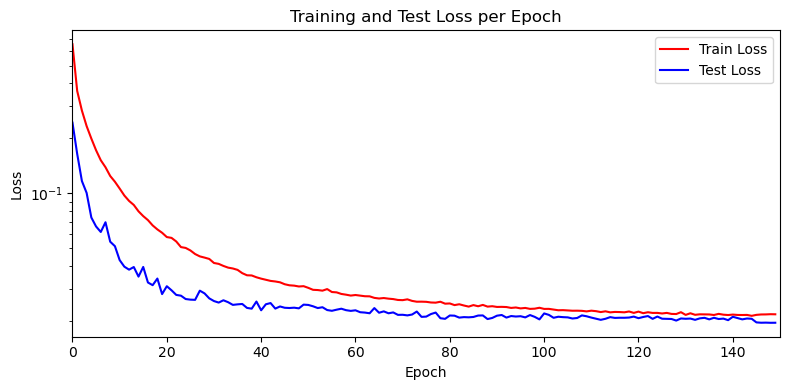

In [125]:
epochs_range = np.arange(epochs)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(epochs_range, losses_train, label='Train Loss', color='red')
ax.plot(epochs_range, losses_test, label='Test Loss', color='blue')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_title('Training and Test Loss per Epoch')
ax.legend()
plt.xlim(0, epochs)
plt.yscale('log')
plt.tight_layout()
plt.show()

**Observaciones**  
La perdida de entrenamiento y test es practicamente la misma, lo que indica que el modelo no presenta overfitting.

### Paso de delta a valores de vela

1. Se obtienen las predicciones de test y el precio de cierre anterior
2. Se reescala el precio de cierre
3. Se calculan los precios aplicando la formula de delta a la inversa: ($\Delta$ + 1) * cierre_anterior

In [126]:
model.eval()
with torch.inference_mode():
    delta_open_pred, delta_high_pred, delta_low_pred, delta_close_pred = model(X_seq_test, X_est_test)

idx_cierre_anterior = dict_est['Cierre_Anterior']

cierre_anterior_scaled = X_est_test[:, idx_cierre_anterior].unsqueeze(1).cpu().numpy()
cierre_anterior_real = scaler_cierre_anterior.inverse_transform(cierre_anterior_scaled)

delta_open_pred = delta_open_pred.cpu().numpy()
delta_high_pred = delta_high_pred.cpu().numpy()
delta_low_pred = delta_low_pred.cpu().numpy()
delta_close_pred = delta_close_pred.cpu().numpy()

In [127]:
# La formula de delta pero al revés
real_open_pred = (delta_open_pred + 1) * cierre_anterior_real
real_high_pred = (delta_high_pred + 1) * cierre_anterior_real
real_low_pred = (delta_low_pred + 1) * cierre_anterior_real
real_close_pred = (delta_close_pred + 1) * cierre_anterior_real

real_open_pred = real_open_pred.flatten()
real_high_pred = real_high_pred.flatten()
real_low_pred = real_low_pred.flatten()
real_close_pred = real_close_pred.flatten()


velas_pred = np.stack([real_open_pred, real_high_pred, real_low_pred, real_close_pred], axis=1)
velas_test.shape, velas_pred.shape

velas_test = scaler_velas.inverse_transform(velas_test)

### Calculo del Error Absoluto Medio (MAE)

In [128]:
# Crear el DataFrame con valores reales y predichos
df_results = pd.DataFrame(
            np.abs(velas_test - velas_pred),
            columns=['Open_error', 'High_error', 'Low_error', 'Close_error']
)
df_results.mean()

Open_error     0.063572
High_error     0.100541
Low_error      0.123568
Close_error    0.146251
dtype: float32

**Observaciones**  
Teniendo en cuenta que la acción de repsol suele estar entre 10 y 15€ un error de entre 6 y casi 14 céntimos invalida por completo el modelo

### Visualización de las predicciones junto a los valores reales

In [129]:
# Se toman las últimas fechas del índice de repsol, igual al tamaño de df_results
fechas_test = repsol.index[-len(df_results):]

df_results['Fecha'] = fechas_test

fig = go.Figure()
# Aumentar el tamaño de la figura
fig.update_layout(height=700)

# Velas reales
fig.add_trace(go.Candlestick(
    x=df_results['Fecha'],
    open=velas_test[:, 0],
    high=velas_test[:, 1],
    low= velas_test[:, 2],
    close= velas_test[:, 3],
    name='Real',
    increasing_line_color='green',
    decreasing_line_color='red',
    opacity=1
))

# Velas predichas
fig.add_trace(go.Candlestick(
    x=df_results['Fecha'],
    open=real_open_pred,
    high=real_high_pred,
    low= real_low_pred,
    close= real_close_pred,
    name='Predicción',
    increasing_line_color='orange',
    decreasing_line_color='blue',
    opacity= 0.75,
    showlegend=True
))

fig.update_layout(
    title='Gráfico de Velas: Real vs Predicción (Test)',
    xaxis_title='Fecha',
    yaxis_title='Precio (€)',
    template='plotly_dark',
    legend=dict(x=0.01, y=0.99)
)
fig.show()

**Observaciones**  
Gracias a las restricciones impuestas dentro del modelo (High es el valor más alto y Low el más bajo) las velas mantienen una forma coherente, sin embargo se observa con claridad que el cuerpo de las velas es muy fino, casi todas las velas son idénticas con la única diferencia apreciable siendo el precio de apertura.

## Conclusión
En este estudio se construyó y probó un modelo basado en un GRU bidireccional combinado con entrada estática para predecir la cotización diaria de Repsol. Aunque la implementación fue funcional y sin sobreajuste evidente, los resultados demuestran que el modelo actual no alcanza precisión útil: sus predicciones tienen tendencia a ser prácticamente constantes, con errores medios de hasta 0.15 € por vela. Esto sugiere un sesgo alto en el modelo.

La propuesta sirve como punto de partida para prototipado; se requieren mejoras sustanciales en la ingeniería de características, arquitectura o formulación de la tarea para lograr pronósticos más finos.

Las lecciones aprendidas indican que combinar datos históricos con indicadores técnicos es viable, pero capturar la verdadera volatilidad de una acción exige modelos más avanzados y estrategias de entrenamiento refinadas. En futuros trabajos, se explorará estas mejoras con el fin de obtener predicciones de cotización con mayor utilidad.